# Gradient correction
- Version: 0.2
- Last update: 2023.12.13
- Author: Yu-Le Wu

**Disclaimer: this script has not been tested by a 2nd person yet. Please let me know your feeback.**

# 0. Folder structure
- `base_dir`
    - `project_name`
        - image_data (*this is the folder containing the fovs to be corrected*)
        - gradient_correction (*all files generated by this script will be saved here*)
            - correction_intermediate (*temparay files. Usually you can ignore this folder*)
            - **correction_viz** (*you can find the before/after comparison here*)
            - **image_data** (*the corrected images are saved here*)

## 1. Import requried packages
This part can take a while (a few minutes)

In [29]:
# import sys
# sys.path.append('../toffy_repo/')
# import run_info_batch_SMP2023 as config

In [30]:
import tifffile
import os
import cv2
import numpy as np
import pandas as pd
import seaborn_image as isns
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from skimage import exposure
import skimage
import seaborn as sns

from skimage.morphology import disk
from skimage.filters import median

## 2. Specify basic information
### 2.1. Specify the working directory
The base_dir should be the one where the folder image_data is

In [38]:
base_dir = "/Volumes/VERBATIM HD/Hamburg Project"        # where the project folder is
project_name = "Image_data"    # the name of the project folder

### 2.2. Specify the path to the panel csv file
This should be the file created by toffy

In [39]:
config = {'panel_path':'/Volumes/VERBATIM HD/Hamburg Project/MIBI/CRC_TMA_panel_MSVA_TG.csv'} # replace "/omics/groups/OE0622/internal/mibi_raw_data/Panel46_ST0026_retry.csv" with your own file

In [59]:
os.chdir(base_dir)
imageData_dir = os.path.join(base_dir, project_name)
FOVs = os.listdir(imageData_dir)

FOVs = [item for item in FOVs if os.path.isdir(os.path.join(imageData_dir, item))]
FOVs = sorted(FOVs)

In [ ]:
gradient_correction_dir = os.path.join(base_dir, project_name, "gradient_correction")
if not os.path.exists(gradient_correction_dir):
    os.mkdir(gradient_correction_dir)

### 2.3. Specify the channels
Here we should use the markers that are expressed in most of the cells, or we can say these markers have continuous distributions. In our cases, they are mostly the metabolic markers.

In [41]:
# Specify the name and the mass of the channels
channels_mass = {'nuclei':115,'CD98':141,'CytC':142,'MCT1':146,'ASCT2':150,'LDH':152,'GS':157,'GLS':160,'ATP5A':162,'CS':163,'PKM2':165,'GLUT1':166,'CPT1A':173,'membrane':176, 'MSH2':144}

## 3. Gradient estimation
Every channel is summed up over all FOVs. The sum is then blurred strongly by applying a Gaussian filtering with large Sigma before applying a median filtering. The highly blurred sum is then the gradient estimate

In [42]:
sigma = 150                        # specify the Gaussian sigma here
diameter_median_filtering = 2     # the diameter of the median filtering
FOVs = [item for item in FOVs if 'prescan' not in item]
margin = 100
margin_expansion = False

### 3.1. Calculate the sum

In [8]:
img_ch = {}
channels = channels_mass.keys()

channel_sum_dir = os.path.join(gradient_correction_dir, "correction_intermediate")
if not os.path.exists(channel_sum_dir):
    os.mkdir(channel_sum_dir)

# Loop through each channel
for ch in list(channels):
    # For each channel, loop through all FOVs
    for k, FOV in enumerate(FOVs):
        # Locate the tiff files
        folderPath = os.path.join(imageData_dir, FOV, 'rescaled')
        files = os.listdir(folderPath)
        fname = os.path.join(folderPath, ch + '.tiff')
        
        # Read one tiff
        img = skimage.io.imread(fname)
        dim = np.array(img).shape
        
        # This part is not used and might be removed later
        if margin_expansion:
            # expaned image with mirrored edges
            img_fliplr = np.fliplr(img)
            img_flipud = np.flipud(img)
            img_flip2 = np.flip(img, axis=[0,1])

            img_top_bottom = np.concatenate((img_flip2, img_flipud, img_flip2),axis=1)
            img_mid = np.concatenate((img_fliplr, img, img_fliplr),axis=1)
            img_tile = np.concatenate((img_top_bottom, img_mid, img_top_bottom),axis=0)

            img = img_tile[(dim[0]-margin-1):(2*dim[0]+margin),(dim[0]-margin-1):(2*dim[0]+margin)]
        else:
            margin = 0
        
        # Sum up all tiff files from the channel over all FOVs
        if k == 0:
            img_sum = img
        else:
            img_sum = img_sum+img
    
    # Export the sum per channel
    imsave(os.path.join(gradient_correction_dir, 'correction_intermediate', ch + '_sum.tiff'), img_sum,check_contrast=False)
    

### 3.2. Perform the image filtering

In [9]:
img_ch = {}
for ch in channels:
    fname = os.path.join(gradient_correction_dir, 'correction_intermediate', ch + '_sum.tiff')
    # Read one tiff
    img_sum = skimage.io.imread(fname)
    
    # Strongly blurr the sum
    img_g = skimage.filters.gaussian(img_sum, sigma=sigma)
    
    # Median filtering (this might not be necessary)
    imsave(os.path.join(gradient_correction_dir, 'correction_intermediate', ch + '_blurred.tiff'), img_g,check_contrast=False)
    med = median(img_g, disk(diameter_median_filtering))
    
    # Normalize to have the maximum as 1
    med_norm = med/med.max()
    
    # Save the processed image channel-by-channel
    imsave(os.path.join(gradient_correction_dir, 'correction_intermediate', ch + '_final.tiff'), med_norm,check_contrast=False)
    img_ch[ch] = med_norm

## 4. Visualization and export
### 4.1 Display all specified channels as a gallery

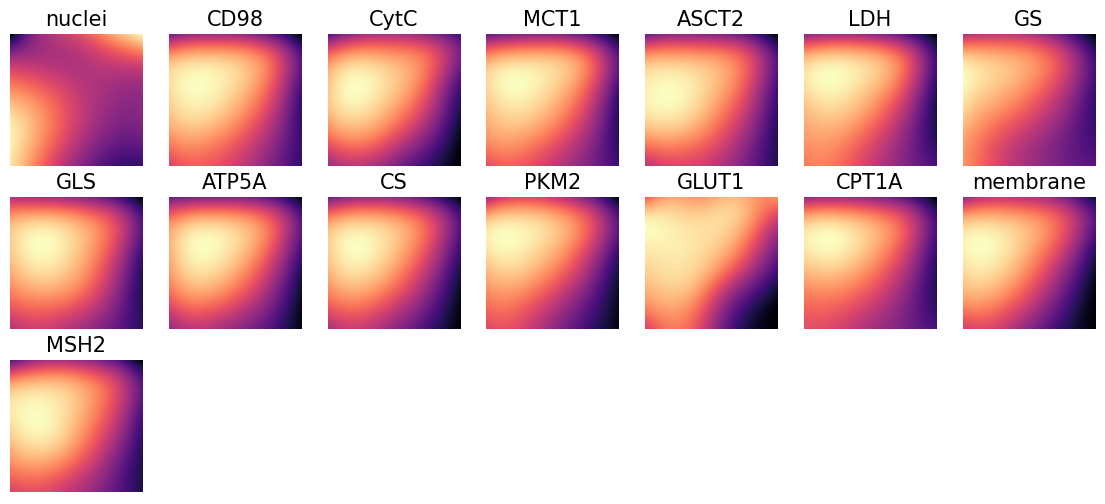

In [10]:
fig, axes = plt.subplots(3, 7, figsize=(14, 6), sharey=True)
axes = axes.flatten()
magma = sns.color_palette("magma", as_cmap=True)
pt = 0.1
for ax in axes:
    ax.grid(False)
    ax.axis('off')

# Make the plots and calculate the signal drop
min_val = []
for k, key in enumerate(img_ch):
    ax = axes[k]
    img_crop = img_ch[key][margin:margin+dim[1]-1,margin:margin+dim[1]-1]
    ax.imshow(img_crop, cmap=magma)
    ax.title.set_text(list(channels)[k])
    
    # Calculate the signal drop
    if k == 0:
        min_val = np.percentile(img_crop, pt)
    else:
        min_val = np.hstack((min_val, np.percentile(img_crop, pt)))

### 4.2 Export the gallery

In [11]:
fig.savefig(os.path.join(gradient_correction_dir, 'correction_intermediate', 'gradient_metabolic_markers.png'), dpi=600)

## 5. Generating the correction matrix
Here, we want to create a shared correction matrix and scale it channel-by-channel before applying it
In theory, the correction matrix (i.e., the pattern of the gradient) should be the same for all channels. But how much the signal drops (i.e., range of the gradient) might be channel-specific. In my onw test, I found a linaer relation between the signal drop and the channel mass so we can calibrate it.
### 5.1. Specify the channel matrix to be included
Look at the gallery above. Most of the channels should look similar. **If not, then this approch does not suit the current dataset.** Only include the channels that have similar and most common pattern in the list `used_channel`

In [43]:
# Specify the name and the mass of the channels
used_channel = {'CD98':141,'CytC':142,'MCT1':146,'ASCT2':150,'LDH':152,'GS':157,'GLS':160,'ATP5A':162,'CS':163,'PKM2':165,'GLUT1':166,'CPT1A':173,'membrane':176, 'MSH2':144}

### 5.2. Create the shared correction matrix

In [13]:
correction_matrix = np.zeros((dim[0], dim[1]))
for key in used_channel.keys():
    correction_matrix = correction_matrix + img_ch[key]
    
correction_matrix = correction_matrix/correction_matrix.max()

Text(0.5, 1.0, 'Shared correction matrix')

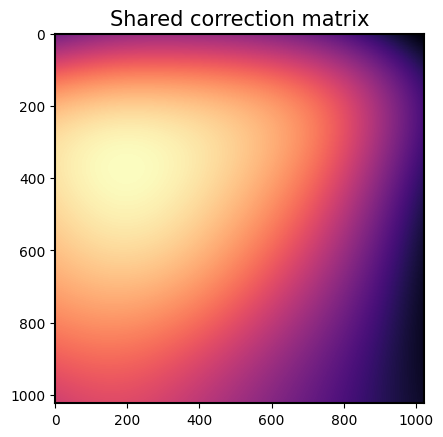

In [14]:
plt.imshow(correction_matrix, cmap=magma)
plt.title('Shared correction matrix')

### 5.3. Visualize the relation between signal drop and channel mass

/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/pre-processing/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'signal drop')

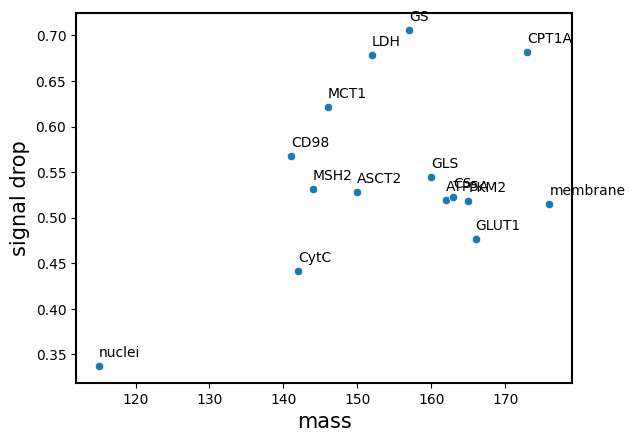

In [15]:
x = list(channels_mass.values())
y = 1-min_val
text = list(channels_mass.keys())
sns.scatterplot(x=x, y=y)
for i in range(len(x)): 
    plt.annotate(text[i], (x[i], y[i] + 0.01))
    
plt.xlabel('mass')
plt.ylabel('signal drop')

### 5.4. Calibrate the drop by mass
Only are the specified `used_channel` included in the computation of the calibration curve 

In [16]:
l_used_channel = pd.Series(text).isin(used_channel.keys())

x_fit = np.array(x)[l_used_channel.to_numpy()]
y_fit = np.array(y)[l_used_channel.to_numpy()]
text_fit = np.array(text)[l_used_channel.to_numpy()]

coef = np.polyfit(x_fit, y_fit, 1)

Text(0, 0.5, 'signal drop')

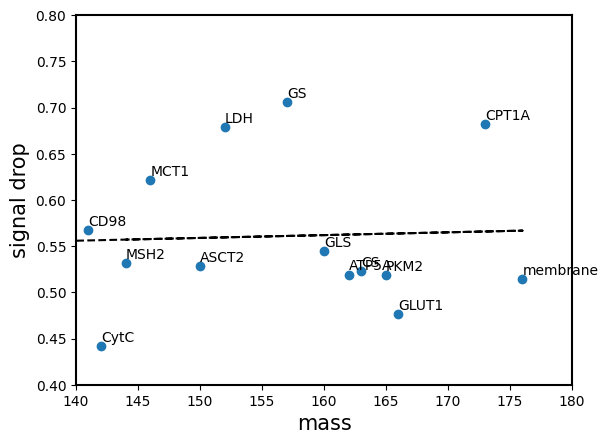

In [19]:
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(x_fit,y_fit, 'o', x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
for i in range(len(x_fit)): 
    plt.annotate(text_fit[i], (x_fit[i], y_fit[i] + 0.005))
plt.xlim(140, 180)
plt.ylim(0.4, 0.8)
plt.xlabel('mass')
plt.ylabel('signal drop')

In [46]:
def load_derivative_csv(csv_path):
    # Extract file name and directory from the path
    dir_path, file_name = os.path.split(csv_path)
    
    # Check if the file name contains '.csv'
    if file_name.endswith('.csv'):
        # Remove '.csv' extension
        base_name = file_name[:-4]
        
        # Derivative file name-
        derivative_name = f"{base_name}.csv"
        
        # Derivative file path
        derivative_path = os.path.join(dir_path, derivative_name)
        
        # Check if the derivative file exists
        if os.path.exists(derivative_path):
            # Load the derivative CSV
            df_derivative = pd.read_csv(derivative_path)
            
            return df_derivative
        else:
            print(f"Derivative file '{derivative_name}' not found.")
    else:
        print("Invalid CSV file path.")


## 6. Apply the correction
Now the correction will be applied to all channels in all FOVs

In [57]:
# Loading the panel
panel = load_derivative_csv(config['panel_path'])
corrected_image_dir = '/Volumes/VERBATIM HD/Hamburg Project/gradient_correction/image_data_corrected'

In [60]:
FOVs

['A1a',
 'A1c',
 'A1d',
 'A1e',
 'A1f',
 'A1g',
 'A1h',
 'A1i',
 'A1k',
 'A1l',
 'A1m',
 'A1n',
 'A1o',
 'A1p',
 'A1q',
 'A1r',
 'A2a',
 'A2b',
 'A2c',
 'A2d',
 'A2e',
 'A2g',
 'A2h',
 'A2i',
 'A2k',
 'A2l',
 'A2m',
 'A2n',
 'A2o',
 'A2p',
 'A2q',
 'A2r',
 'A3a',
 'A3b',
 'A3c',
 'A3d',
 'A3e',
 'A3f',
 'A3g',
 'A3h',
 'A3i',
 'A3l',
 'A3m',
 'A3n',
 'A3o',
 'A3p',
 'A3q',
 'A3r',
 'A4a',
 'A4b',
 'A4c',
 'A4d',
 'A4e',
 'A4f',
 'A4g',
 'A4h',
 'A4i',
 'A4k',
 'A4l',
 'A4m',
 'A4n',
 'A4o',
 'A4p',
 'A4q',
 'A4r',
 'A5a',
 'A5b',
 'A5c',
 'A5d',
 'A5e',
 'A5f',
 'A5g',
 'A5h',
 'A5i',
 'A5k',
 'A5l',
 'A5m',
 'A5n',
 'A5o',
 'A5p',
 'A5q',
 'A5r',
 'A6a',
 'A6b',
 'A6c',
 'A6d',
 'A6e',
 'A6g',
 'A6h',
 'A6i',
 'A6k',
 'A6l',
 'A6m',
 'A6n',
 'A6o',
 'A6p',
 'A6q',
 'A6r',
 'A7a',
 'A7b',
 'A7c',
 'A7d',
 'A7f',
 'A7g',
 'A7h',
 'A7i',
 'A7k',
 'A7l',
 'A7m',
 'A7n',
 'A7o',
 'A7p',
 'A7q',
 'A7r',
 'A8a',
 'A8b',
 'A8c',
 'A8d',
 'A8e',
 'A8f',
 'A8g',
 'A8h',
 'A8i',
 'A8l',
 'A8m',


In [61]:
# Going through the images one by one
correction_matrix_p1 = np.percentile(correction_matrix, pt)
drop = 1-correction_matrix_p1
for index, channel in panel.iterrows():
    target_drop = poly1d_fn(channel.Mass)
    fold_drop = target_drop/drop
    correction_matrix_ch = correction_matrix*fold_drop
    correction_matrix_ch = correction_matrix_ch-np.max(correction_matrix_ch)+1
    
    for k, FOV in enumerate(FOVs):
        # Locate the tiff files
        folderPath = os.path.join(imageData_dir, FOV, 'rescaled')
        fname = os.path.join(folderPath, channel.Target + '.tiff')
        
        # Read one tiff
        img_ch = skimage.io.imread(fname)
        
        # Rescale the correction_matrix to have a 1st percentile of the regressed value per channel
        img_corrected = img_ch/correction_matrix_ch

        path_fov = os.path.join(corrected_image_dir, FOV)
        save_to = os.path.join(path_fov, channel.Target + '.tiff')
        
        if not os.path.exists(path_fov):
            os.mkdir(path_fov)
        
        imsave(save_to, img_corrected, check_contrast=False)       
print('The correction is done!')

The correction is done!


## 7. Visualization
Here we want to check the effect of the gradient correction by comparing FOVs before/after the correction.
### 7.1. Specify the FOVs to inspect

In [74]:
# Subset of FOVs you want to display
# substring = 'C1'
# selected = ['2023-03-10-ST0026_set5_C9_CoCa','2023-03-10-ST0026_set4_H9_CoCa','2023-03-10-ST0026_set3_D4_Live','2023-03-09-ST0026_set2_F9_CoCa','2023-03-09-ST0026_set1_B10_Mamm']
FOVs_subset = ['A1e','A1h','A1i','A1k','A1m', 'A1o', 'A1p', 'A2l' ]

In [75]:
df = pd.Series(FOVs_subset)
df_FOVs = pd.DataFrame(FOVs_subset, columns=['fov'])

In [41]:
# # Define a pattern using regular expression
# pattern = r'\w+_pos(\d+)_(\d+)_(\w+)'

# Extract matches using str.extract
# df_FOVs = pd.DataFrame(FOVs_subset, columns=['fov'])
# df_FOVs[['pos', 'subpos', 'condition']] = df_FOVs['fov'].str.extract(pattern)

# # Convert extracted columns to numeric if needed
# df_FOVs[['pos', 'subpos']] = df_FOVs[['pos', 'subpos']].apply(pd.to_numeric, errors='coerce')

# df_FOVs = df_FOVs.sort_values(by=['subpos'], ascending=False)

In [76]:
marker2display = panel.Target
pt = 99
gray = sns.color_palette("gray", as_cmap=True)

In [67]:
imageData_dir

'/Volumes/VERBATIM HD/Hamburg Project/Image_data'

### 7.2. Save the comparisons and display the last channel

/var/folders/wz/d4sltz8j5g921kkhbdghhw5r0000gq/T/ipykernel_76429/2681256239.py:44: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


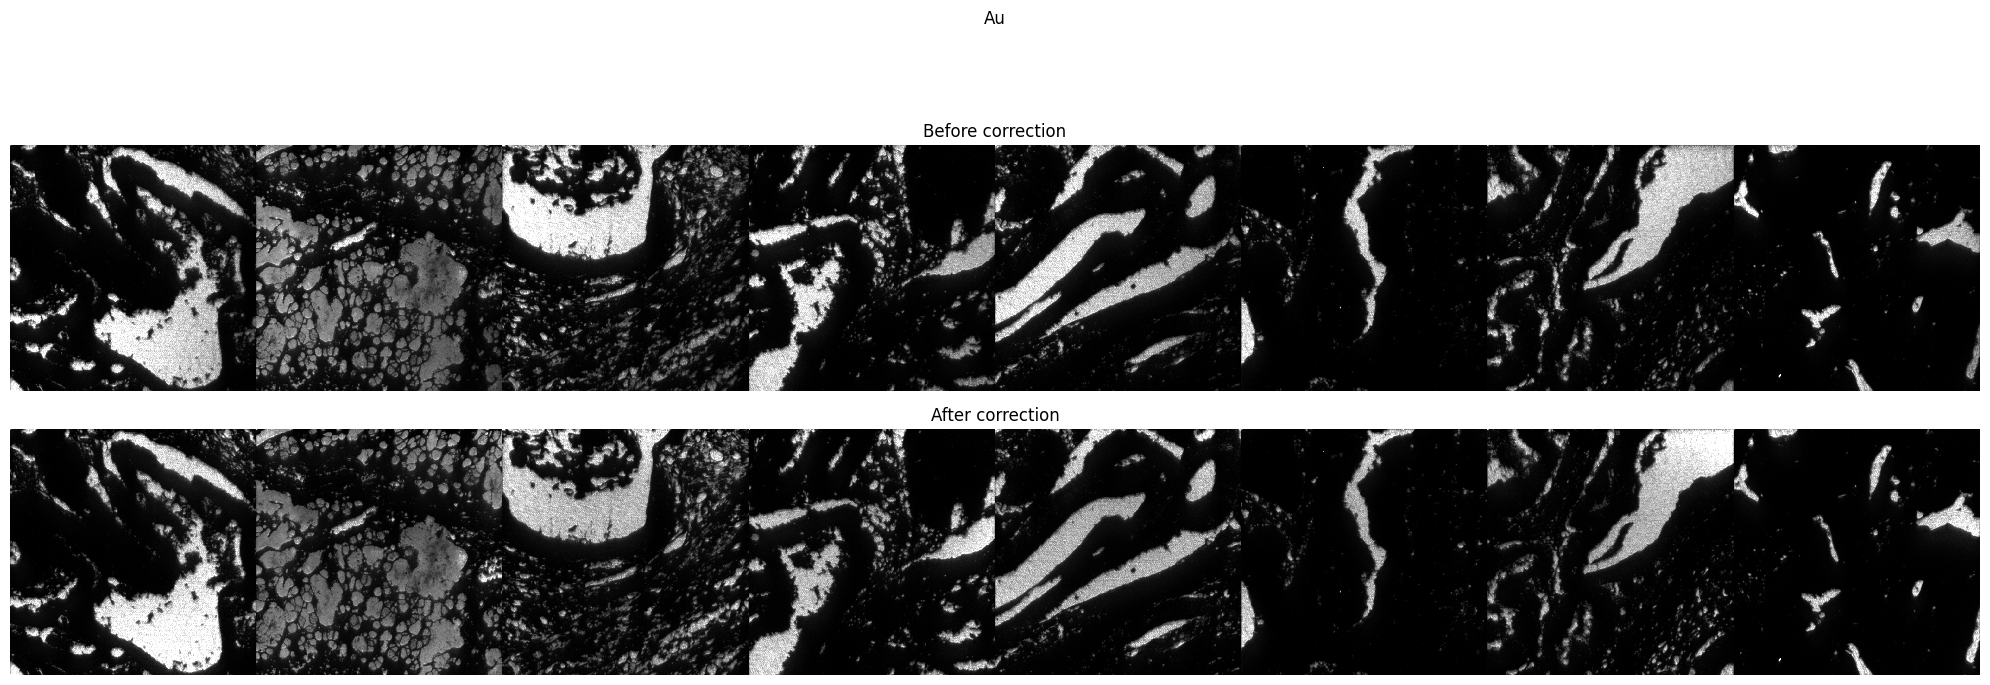

In [77]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharey=True)
axes = axes.flatten()
file_sources = [imageData_dir, corrected_image_dir]
title = ['Before correction','After correction']
for ax in axes:
    ax.grid(False)
    ax.axis('off')

for channel in marker2display:
    fig.suptitle(channel)
    k= 0
    file_source= imageData_dir
    t = 0
    for index, FOV in df_FOVs.iterrows():
        path_fov = os.path.join(file_source, FOV.fov, 'rescaled')
        fname = os.path.join(path_fov, channel + '.tiff')

        img = imread(fname)
        if t == 0:
            t = 1
            img_tiled = img
        else:
            img_tiled = np.concatenate((img_tiled, img),axis=1)
    img_tiled[img_tiled>np.percentile(img_tiled,pt)]=np.percentile(img_tiled,pt)
    axes[k].imshow(img_tiled, cmap=gray)
    axes[k].set_title(title[k], fontsize=12)
    k= 1
    file_source= corrected_image_dir
    t = 0
    for index, FOV in df_FOVs.iterrows():
        path_fov = os.path.join(file_source, FOV.fov)
        fname = os.path.join(path_fov, channel + '.tiff')

        img = imread(fname)
        if t == 0:
            t = 1
            img_tiled = img
        else:
            img_tiled = np.concatenate((img_tiled, img),axis=1)
    img_tiled[img_tiled>np.percentile(img_tiled,pt)]=np.percentile(img_tiled,pt)
    axes[k].imshow(img_tiled, cmap=gray)
    axes[k].set_title(title[k], fontsize=12)
        
    fig.tight_layout()
    fig.savefig(os.path.join("/Volumes/VERBATIM HD/Hamburg Project/gradient_correction/correction_viz",  channel + '_comparison.png'),dpi=300)